# Combining multiple waves into wave packets

A successful wave description of matter needs a way to <strong>localize</strong> the high-amplitude part of the wave function at any point in time. The traveling wave equation
#### $\psi(x,t) = A \sin (kx - \omega t)$
### $\frac{\partial^2 \psi}{\partial x^2} = \frac{1}{v^2} \frac{\partial^2 \psi}{\partial t^2}$
goes on for $x = \pm \infty$, $t = \pm \infty$.

Let's visualize a traveling sinusoid. <strong>To make my code simpler, I set $\lambda = 1$ length unit, $\omega = 1$ cycle per time unit and 1 animation frame = 1/10 time unit.</strong> Thus the function that updates the frame has an implicit multiplication by $\omega = 1$ and the sinusoid has $k = 2 \pi$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
plt.rcParams.update({"font.size":16, "axes.labelsize":16, "font.family":"sans-serif", "font.sans-serif":"Arial"})

fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel('x')
ax.set_ylabel(r"$\psi$")
ax.set_title('Traveling wave')
ax.grid(color='0.85')

x = np.arange(0, 3, 0.02)
sine, = ax.plot(x, np.sin(2*np.pi*x), color='mediumblue', lw=2)

def animate_sine(frame_num):
    sine.set_ydata(np.sin(2*np.pi*x - frame_num / 10))  # update the data.
    return sine,

ani_sine = animation.FuncAnimation(fig, animate_sine, frames=200)
sine_video = ani_sine.to_html5_video()
html = display.HTML(sine_video)
display.display(html)

plt.close()

The probability function is given by $\psi^2(x,t)$ if $\psi(x,t)$ is real-valued, or the product $\psi^*(x,t) \psi(x,t)$ if $\psi(x,t)$ is complex-valued. The probability function associated with our traveling wave is $\sin^2 (kx - \omega t)$, which has lots of peaks (an infinite number, in fact). The particle could be <strong>almost</strong> anywhere. The only x-coordinates forbidden by this wave function are the points where $\psi(x,t) = 0$.

Another problem with our traveling sine wave is that it's impossible to normalize$^{\star}$ it so that $\psi^2(x,t)$ integrates to 1. All probability distributions have to integrate to exactly 1, not more, not less. But with an infinite number of peaks in $\sin^2(kx - \omega t)$, we'd have to normalize as $\psi(x,t) = A \sin (kx - \omega t) / \infty$, which is nonsensical.

$^{\star}$normalize = set the amplitude

To describe an object that's localized in space, like an electron, we want our wave function to consist of a "bump" - a place of high amplitude - with the amplitude declining towards zero on either side of the bump. Something like this:

In [2]:
fig2, ax2 = plt.subplots(figsize=(9,5))
ax2.set_xlabel('x')
ax2.set_ylabel(r"$\psi$")
ax2.set_title('Traveling Gaussian')
ax2.grid(color='0.85')

x2 = np.arange(-3, 3, 0.02)
# Below x2 is implicitly divided by 1 length unit, which is the width of our Gaussian.
#   Dividing by the width gives a dimensionless argument to the exponential. 
Gauss, = ax2.plot(x2, np.exp(-0.5*(x2+3)**2) / np.sqrt(2*np.pi), color='mediumblue', lw=2)

# This animation has 20 frames per time unit
def animate_Gauss(frame_num):
    Gauss.set_ydata(np.exp(-0.5*(x2+3 - frame_num/20)**2) / np.sqrt(2*np.pi))  # update the data.
    return Gauss,

ani_Gauss = animation.FuncAnimation(fig2, animate_Gauss, frames=120)

Gauss_video = ani_Gauss.to_html5_video()
html = display.HTML(Gauss_video)
display.display(html)
plt.close()

Our probability functions will consist of traveling <strong>wave packets</strong>. A packet is a combination of many waves. We can express a packet as a sum of sinusoids, or <strong>Fourier series</strong>:
### $\psi(x,t) = \sum_{i} A_i \cos (k_i x - \omega_i t)$.     (1)
$k_i$ and $\omega_i$ can't take on any random values: they are linked by the wave speed, $v_i = \omega_i / k_i$. Yes, we may have to deal with the possibility that different wavelengths / frequencies travel at different speeds; this is called dispersion.

If all $v_i$ are the same, the wave function is traveling through a <strong>non-dispersive</strong> medium, an example of which is light in a vacuum. In this case, the wave packet will keep the same shape forever. On the other hand, if the $v_i$ depend on wavelength/frequency, a highly localized wave packet won't hang together - at some point in the future, it will have spread out.

We distinguish between the speed of each individual wavelength/frequency combination $v_i$, which we call the <strong>phase velocity</strong>, and the speed of the entire wave packet, which we call the <strong>group velocity</strong>. The group velocity is
### $u_{\rm gr} = \frac{d \omega}{d k} \Bigr|_{k_0}$,
evaluated at the wavenumber $k_0$ at which $\psi(x,t)$ has the highest absolute value (the "center" of the wave packet).

#### To go from a wave treatment to a particle treatment, we equate $u_{\rm gr}$ with the velocity of the particle.

### Demo of localized wave packet

We are going to create a non-dispersive, semi-localized (semi because a plot of a large number of waves would be unreadable), traveling wave packet. We'll use a <strong>truncated Fourier series</strong>, which is a version of Equation (1) in which the sum does not go up to $i = \infty$ but stops at a finite $i$. Note, I use spatial frequency $\xi_i = 1 / \lambda_i$ (units: cycles per length unit) in my wave function definitions instead of wavelength or angular frequency because it's easy for me to visualize how spatial frequency will manifest on a plot.

First we define a function that calculates the wave packet's Fourier series:

In [3]:
frequency_scale = 0.05

# The amplitude of the waves in this wave packet will be set by the sinc function, 
#   which is sin(pi xi/xi_0) / (pi xi/xi_0). N is the number of waves in the Fourier series.
#   I chose a sinc function because if you add up ALL the waves with frequencies defined
#   by the sinc in a continuous domain (i.e. all the fractional frequencies plus integers),
#   you get a perfectly localized rectangle.
def wave_packet(N, x):
    amplitudes = np.zeros(N)
    Fourier_components = np.zeros((N, len(x)))
    center = N // 2
    for i in range(N):
        # We set the spatial frequency (number of waves per unit length)
        #   using i+1 instead of i so as to avoid zero frequency, which is just a constant
        spatial_frequency = frequency_scale * (i + 1)
        # Below, there is an implicit division by spatial frequency xi_0 = 1 
        #   so as to keep the sin() argument dimensionless
        amplitudes[i] = np.sin(np.pi * spatial_frequency) / (np.pi * spatial_frequency)
        Fourier_components[i,:] = amplitudes[i] * np.cos(2 * np.pi * x * spatial_frequency)
    packet = np.sum(Fourier_components, axis=0)
    return packet, amplitudes

Next we calculate the individual waves at an arbitrary time $t$ for a packet consisting of 11 waves:

Text(0.5, 1.0, 'Waves at time $t$')

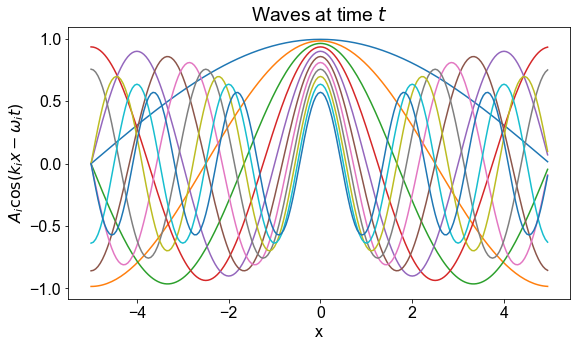

In [4]:
x3 = np.arange(-5, 5, 0.05)
NN = 11
packet_11, amplitudes_11 = wave_packet(NN, x3)

plt.figure(figsize=(9,5))
for i, a in enumerate(amplitudes_11):
    spatial_frequency = frequency_scale * (i + 1)
    plt.plot(x3, a*np.cos(2*np.pi*x3*spatial_frequency)) # Dimensionless argument to cos()

plt.xlabel('x')
plt.ylabel(r"$A_i \cos(k_i x - \omega_i t)$")
plt.title(r"Waves at time $t$")

Now we plot the packet, which is the sum of the individual waves pictured above, at time $t$:

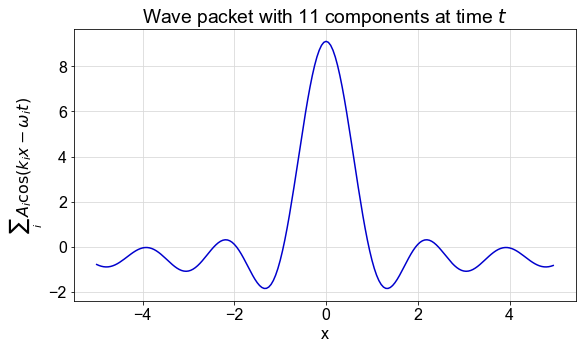

In [5]:
plt.figure(figsize=(9,5))
plt.plot(x3, packet_11, color='mediumblue')
plt.xlabel('x')
plt.ylabel(r"$\sum_i \, A_i \cos(k_i x - \omega_i t)$")
plt.title(r"Wave packet with 11 components at time $t$")
plt.grid(color='0.85')

#### Now let's make our non-dispersive wave packet travel:

In [6]:
fig3, ax3 = plt.subplots(figsize=(9,5))
ax3.set_xlabel('x')
ax3.set_ylabel(r"$\psi$")
ax3.set_title('Traveling Fourier series wave packet')

packet_plot, = ax3.plot(x3+5, wave_packet(NN, (x3 + 5))[0], color='mediumblue', lw=2)

def animate_packet(frame_num):
    packet_plot.set_ydata(wave_packet(NN, (x3 + 5 - frame_num/20))[0])  # update the data.
    return packet_plot,

ani_packet = animation.FuncAnimation(fig3, animate_packet, frames=150)
packet_video = ani_packet.to_html5_video()
html = display.HTML(packet_video)
display.display(html)
plt.close()

#### Finally, let's see what a traveling dispersive wave packet looks like

<p>We'll create a truncated Fourier series in which wave speed $v_i$ depends on wavelength. In the <tt>dispersive_wave_packet()</tt> function, wave speed comes into play when we use the cosine function to calculate each sinusoid in the Fourier series, in the line<br />
<tt>Fourier_components[i,:] = amplitudes[i] * np.cos(2 * np.pi * x * spatial_frequency - 0.5*t*N/(i+1))</tt><br />
(\ is a line continuation character). The waves have their displacement in the +x direction multiplied by a factor that's inversely proportional to loop index $i$ and directly proportional to time $t$, which is given by the animation frame number. The result is that the longer-wavelength waves travel faster than the shorter-wavelength ones. Watch the shape of the wave packet "melt" as the animation progresses.</p>

In [7]:
def dispersive_wave_packet(N, x, t):
    amplitudes = np.zeros(N)
    Fourier_components = np.zeros((N, len(x)))
    center = N // 2
    for i in range(N):
        spatial_frequency = frequency_scale * (i + 1) # Unlike in wave_packet(), high i -> long wavelength
        amplitudes[i] = np.sin(np.pi * spatial_frequency) / (np.pi * spatial_frequency)
        Fourier_components[i,:] = amplitudes[i] * \
                                  np.cos(2 * np.pi * x * spatial_frequency - 0.003*t*N/(i+1))
    packet = np.sum(Fourier_components, axis=0)
    return packet, amplitudes

In [8]:
x4 = np.arange(-10, 10, 0.05)

fig4, ax4 = plt.subplots(figsize=(9,7))
ax4.set_xlabel('x')
ax4.set_ylabel(r"$\psi$")
ax4.set_title('Traveling dispersive wave packet')
ax4.set_xlim([-2,8])
ax4.set_ylim([-10,12])

# Start with the same wave packet as above
dispersive_packet_plot, = ax4.plot(x4+2, dispersive_wave_packet(NN, (x4 + 2), 0)[0], color='mediumblue', lw=2)

# Here is where the dispersion happens. The animation has one frame per time unit, so
#   the total simulation time is just the frame number (frame_num)
def animate_dispersive_packet(frame_num):
    dispersive_packet_plot.set_ydata(dispersive_wave_packet(NN, (x4 + 2 - frame_num/30), frame_num)[0])  # update the data.
    return dispersive_packet_plot,

ani_dispersive_packet = animation.FuncAnimation(fig4, animate_dispersive_packet, frames=130)
dispersive_packet_video = ani_dispersive_packet.to_html5_video()
html = display.HTML(dispersive_packet_video)
display.display(html)
plt.close()